# ML for PM & Trading
---
## Project Proposal: Study of the Links Between Gold Market and US Debt

### This project aims to explore the relationships between the gold market, US debt, and other macroeconomic data such as Federal Reserve (FED) rates using machine learning techniques. By analyzing historical data and applying various ML and Statistical models, we hope to uncover patterns and insights that can inform portfolio management and trading strategies.

- ``Authors`` : Paul-Antoine FRUCHTENREICH & Bilal BENHANA 
- ``Date`` : 2024

## API and package init

In [ ]:
#pip install kagglehub
#pip install seaborn
#pip install statsmodels
#pip install imblearn

In [4]:
import requests
import json
import pandas as pd
import numpy as np
from seaborn import heatmap

import kagglehub
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, BaseCrossValidator, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, mean_absolute_percentage_error, r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score
from sklearn.decomposition import PCA, NMF
from functools import reduce

In [ ]:
# Dictionary to map dataset IDs to their corresponding endpoints

dataset_endpoints = {
    'debt_to_penny': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/debt_to_penny',
    'average_interest_rate': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/avg_interest_rates',
    'tips_cpi': 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/tips_cpi_data_detail'
}

def fetch_data(dataset_id, start_date, end_date, sort='record_date'):
    """
    Fetch data from the specified dataset endpoint with optional parameters.

    :param dataset_id: str, ID of the dataset to fetch (e.g., 'debt_to_penny', 'average_interest_rate', 'tips_cpi')
    :param start_date: str, start date for the data in 'YYYY-MM-DD' format
    :param end_date: str, end date for the data in 'YYYY-MM-DD' format
    :param sort: str, field to sort the data by (default is 'record_date')
    :return: dict, JSON response from the API
    """
    days = (datetime.datetime.strptime(end_date, '%Y-%m-%d') - datetime.datetime.strptime(start_date, '%Y-%m-%d')).days
    
    if days > 10000:
        raise ValueError(f"The maximum range of data that can be fetched is 10000 days (approximately 27 years). Here, the range is {days} days. (approximately {days//365} years).")

    if dataset_id not in dataset_endpoints:
        raise ValueError(f"Invalid dataset_id. Available options are: {list(dataset_endpoints.keys())}")

    url = dataset_endpoints[dataset_id]
    params = {
        'filter': f'{sort}:gte:{start_date},{sort}:lte:{end_date}',
        'sort': sort,
        'page[number]': 1,
        'page[size]': days
    }
    response = requests.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code} - {response.text}")

    df = pd.DataFrame(json.loads(response.text)['data'])
    return df

# Example usage:

"""

debt_to_penny_df = fetch_data('debt_to_penny', '2020-01-01', '2021-01-01')
average_interest_rate_df = fetch_data('average_interest_rate', '2020-01-01', '2021-01-01')
tips_cpi_df = fetch_data('tips_cpi', '1998-01-01', '2020-01-01', sort='original_issue_date')

"""

## Load gold prices and US debt data

### Load the gold price data into a DataFrame

In [ ]:
# Download kaggle dataset of gold price from 1979 to 2022 on a daily basis
path = kagglehub.dataset_download("jishnukoliyadan/gold-price-1979-present")

# The gold with volume, open, high, low, close price  on a daily basis from 1994 to 2021
path_2 = kagglehub.dataset_download("nward7/gold-historical-datasets")

# The gold price in USD on a daily basis
gold_data = pd.read_csv(path + "/Daily_Gold_Price_on_World.csv")
gold_data_usd = gold_data[["Date", "US dollar (USD)"]]
gold_data_usd['Date'] = pd.to_datetime(gold_data_usd['Date'])
gold_data_usd = gold_data_usd.rename(columns={"US dollar (USD)": "usd_price"})
gold_data_usd = gold_data_usd.set_index('Date')
gold_data_2 = pd.read_csv(path_2 + "/Gold_Daily .csv")
gold_data_2['Date'] = pd.to_datetime(gold_data_2['Date'])
gold_data_2 = gold_data_2.rename(columns={"Change %": "Daily_return", "Vol":"Volume"})
gold_data_2 = gold_data_2.set_index('Date')
# convert the volume to numeric
gold_data_2["Volume"] = gold_data_2["Volume"].str.replace("K", "e3")
gold_data_2["Volume"] = pd.to_numeric(gold_data_2["Volume"], errors='coerce')
gold_data_2.dropna()

### Load US debt into a dataset

In [ ]:
# Fetching US debt from 1993 to 2023
debt_to_penny_df_1 = fetch_data('debt_to_penny', '1993-01-01', '2003-01-01')
debt_to_penny_df_2 = fetch_data('debt_to_penny', '2003-01-01', '2023-01-01')
debt_to_penny_df = pd.concat([debt_to_penny_df_1, debt_to_penny_df_2])

# keep only the relevant columns
debt_to_penny_df = debt_to_penny_df[['record_date', 'tot_pub_debt_out_amt']]

# convert  tot_pub_debt_out_amt to numeric in trillions
debt_to_penny_df['record_date'] = pd.to_datetime(debt_to_penny_df['record_date'])
debt_to_penny_df['tot_pub_debt_out_amt'] = pd.to_numeric(debt_to_penny_df['tot_pub_debt_out_amt']) / 1e12  # convert to trillions $
debt_to_penny_df = debt_to_penny_df.set_index('record_date')


#### Periods of interest

In [ ]:
# Define some periods of interest
decenal_periods = {
    '1993-2003': ('1993-01-01', '2003-01-01'),
    '2003-2013': ('2003-01-01', '2013-01-01'),
    '2013-2023': ('2013-01-01', '2023-01-01')
}

# Define all the crisis periods since 1993
crisis_periods = {
    '1997-1998 Asian Financial Crisis': ('1997-07-01', '1998-12-31'),
    '2000-2002 Dot-Com Bubble Burst': ('2000-03-01', '2002-12-31'),
    '2007-2008 Global Financial Crisis': ('2007-07-01', '2008-12-31'),
    '2010-2012 European Debt Crisis': ('2010-01-01', '2012-12-31'),
    '2015-2016 Chinese Stock Market Crash': ('2015-06-01', '2016-12-31'),
    '2019-2020 COVID-19 Pandemic': ('2019-12-01', '2020-12-31')
}

### Load US T-Notes Yields

In [ ]:
path_3 = kagglehub.dataset_download("guillemservera/us-treasury-yields-daily")
us_bonds = pd.read_csv(path_3 + "/us_treasury_yields_daily.csv")
us_bonds["date"] = pd.to_datetime(us_bonds["date"])
us_bonds.set_index("date", inplace=True)
us_bonds

### Features Engineering

In [ ]:
# compute daily returns
gold_data_usd['daily_return'] = gold_data_usd['usd_price'].pct_change()
debt_to_penny_df['daily_return'] = debt_to_penny_df['tot_pub_debt_out_amt'].pct_change()

# compute daily variation
gold_data_usd['daily_variation'] = gold_data_usd['usd_price'].diff()
debt_to_penny_df['daily_variation'] = debt_to_penny_df['tot_pub_debt_out_amt'].diff()

# compute 7d - 28d - 90d - 365 annualized volatility for gold and debt
gold_data_usd['volatility_7d'] = gold_data_usd['daily_return'].rolling(window=7).std() * ((365/7)**0.5)
gold_data_usd['volatility_28d'] = gold_data_usd['daily_return'].rolling(window=28).std() * ((365/28)**0.5)
gold_data_usd['volatility_90d'] = gold_data_usd['daily_return'].rolling(window=90).std() * ((365/90)**0.5)
gold_data_usd['volatility_365d'] = gold_data_usd['daily_return'].rolling(window=365).std()



## Plots

### Gold Price

In [ ]:
gold_data_usd['usd_price'].plot(color='gold')
plt.title('Gold Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.show()

In [ ]:
# plot the gold_data_2 price with volume 
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='gold')
ax1.plot(gold_data_2.index, gold_data_2['Price'], color='gold')
ax1.tick_params(axis='y', labelcolor='gold')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Volume', color='blue')  # we already handled the x-label with ax1
ax2.plot(gold_data_2.index, gold_data_2['Volume'], color='blue', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Gold Price and Volume')
plt.show()


blue too dark -> change opacity

### US Debt

In [ ]:
debt_to_penny_df['tot_pub_debt_out_amt'].plot()

plt.title('US Debt')
plt.xlabel('Date')
plt.ylabel('Debt in Trillions USD')
plt.show()

### US Debt aside Gold Price during some key periods

In [ ]:
def plot_aside(start_date='1979', end_date='2023', crisis_periods=None):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot gold price data
    ax1.plot(gold_data_usd[start_date:end_date].index, gold_data_usd[start_date:end_date]['usd_price'], color='gold', label='Gold Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Gold Price (USD)', color='gold')
    ax1.tick_params(axis='y', labelcolor='gold')

    # Create a second y-axis to plot US debt data
    ax2 = ax1.twinx()
    ax2.plot(debt_to_penny_df[start_date:end_date].index, debt_to_penny_df[start_date:end_date]['tot_pub_debt_out_amt'], color='blue', label='US Debt')
    ax2.set_ylabel('US Debt (Trillions USD)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add title and legend
    plt.title(f'Gold Price and US Debt during {crisis_periods}')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()


# Example usage
for period_name, (start_date, end_date) in decenal_periods.items():
    plot_aside(start_date=start_date, end_date=end_date, crisis_periods=period_name)

In [ ]:
# Make a function that do the bar plot of gold_data_2['Volume'] and line chart of debt_to_penny_df['tot_pub_debt_out_amt'] aside for a given parameter

def plot_aside_2(start_date='1979', end_date='2023', crisis_periods=None):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot gold price data
    ax1.bar(gold_data_2[start_date:end_date].index, gold_data_2[start_date:end_date]['Volume'], color='gold', label='Gold Volume')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Gold Volume', color='gold')
    ax1.tick_params(axis='y', labelcolor='gold')

    # Create a second y-axis to plot US debt data
    ax2 = ax1.twinx()
    ax2.plot(debt_to_penny_df[start_date:end_date].index, debt_to_penny_df[start_date:end_date]['tot_pub_debt_out_amt'], color='blue', label='US Debt')
    ax2.set_ylabel('US Debt (Trillions USD)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add title and legend
    plt.title(f'Gold Volume and US Debt during {crisis_periods}')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

# Example usage

for period_name, (start_date, end_date) in decenal_periods.items():
    plot_aside_2(start_date=start_date, end_date=end_date, crisis_periods=period_name)

for period_name, (start_date, end_date) in crisis_periods.items():
    plot_aside_2(start_date=start_date, end_date=end_date, crisis_periods=period_name)

interpréter les pics très réguliers du volume de l'or, check last trading date pour expliquer les pics réguliers, fin de mois ? fin de semestre ?

### Histogram of returns for gold and Debt

In [ ]:
# Histogram of daily returns for gold and debt

fig, ax = plt.subplots(2, 2, figsize=(14, 7))

gold_data_usd['daily_return'].plot.hist(bins=20, ax=ax[0, 0], color='gold')
ax[0, 0].set_title('Gold Daily Returns')
ax[0, 0].set_xlabel('Daily Return')
ax[0, 0].set_ylabel('Frequency')

debt_to_penny_df['daily_return'].plot.hist(bins=20, ax=ax[0, 1], color='blue')
ax[0, 1].set_title('US Debt Daily Returns')
ax[0, 1].set_xlabel('Daily Return')
ax[0, 1].set_ylabel('Frequency')

gold_data_usd['daily_variation'].plot.hist(bins=20, ax=ax[1, 0], color='gold')
ax[1, 0].set_title('Gold Daily Variation')
ax[1, 0].set_xlabel('Daily Variation')
ax[1, 0].set_ylabel('Frequency')

debt_to_penny_df['daily_variation'].plot.hist(bins=20, ax=ax[1, 1], color='blue')
ax[1, 1].set_title('US Debt Daily Variation')
ax[1, 1].set_xlabel('Daily Variation')
ax[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



enlevable imo

### Heatmap of US Debt Variation and Gold variation

In [ ]:
import seaborn as sns

# Resample the data to daily frequency and fill missing values
debt_daily = debt_to_penny_df.resample('D').ffill()

# Create a pivot table with years as rows and days of the year as columns
debt_daily['Year'] = debt_daily.index.year
debt_daily['DayOfYear'] = debt_daily.index.dayofyear
# Calculate the daily variation in debt
debt_daily['Debt_Variation'] = debt_daily['tot_pub_debt_out_amt'].diff()

# Create a pivot table with years as rows and days of the year as columns for debt variation
debt_variation_pivot = debt_daily.pivot('Year', 'DayOfYear', 'Debt_Variation')

# Plot the heatmap for debt variation
plt.figure(figsize=(12, 8))
sns.heatmap(debt_variation_pivot, center=0, cmap='coolwarm', cbar_kws={'label': 'Debt Variation in  USD'})
plt.title('Heatmap of US Debt Variation by Days')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

# Resample the gold data to daily frequency and fill missing values
gold_daily = gold_data_usd.resample('D').ffill()

# Create a pivot table with years as rows and days of the year as columns
gold_daily['Year'] = gold_daily.index.year
gold_daily['DayOfYear'] = gold_daily.index.dayofyear
# Calculate the daily variation in gold price
gold_daily['Gold_Variation'] = gold_daily['usd_price'].diff()

# Create a pivot table with years as rows and days of the year as columns for gold price variation
gold_variation_pivot = gold_daily.pivot('Year', 'DayOfYear', 'Gold_Variation')

# Plot the heatmap for gold price variation
plt.figure(figsize=(12, 8))
sns.heatmap(gold_variation_pivot, center=0, cmap='coolwarm', cbar_kws={'label': 'Gold Price Variation in USD (Trillions)'})
plt.title('Heatmap of Gold Price Variation by Days')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

# Plot the heatmap for gold volume 
gold_daily_2 = gold_data_2.resample('D').ffill()
gold_daily_2['Year'] = gold_daily_2.index.year
gold_daily_2['DayOfYear'] = gold_daily_2.index.dayofyear
gold_daily_2['Gold_Volume'] = gold_data_2['Volume']

gold_volume_pivot = gold_daily_2.pivot('Year', 'DayOfYear', 'Gold_Volume')

plt.figure(figsize=(12, 8))
sns.heatmap(gold_volume_pivot, center=0, cmap='coolwarm', cbar_kws={'label': 'Gold Volume'})
plt.title('Heatmap of Gold Volume by Days')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()


### Heatmap of US Daily Return and Gold Daily Return

In [ ]:
# Heatmap of Gold daily returns by year
gold_daily['Gold_Return'] = gold_daily['daily_return']
gold_return_pivot = gold_daily.pivot('Year', 'DayOfYear', 'Gold_Return')

plt.figure(figsize=(12, 8))
sns.heatmap(gold_return_pivot, cmap='coolwarm', center=0, cbar_kws={'label': 'Gold Daily Return'})
plt.title('Heatmap of Gold Daily Returns by Days (1979-2022)')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

# Heatmap of Debt daily returns by year
debt_daily['Debt_Return'] = debt_daily['daily_return']
debt_return_pivot = debt_daily.pivot('Year', 'DayOfYear', 'Debt_Return')

plt.figure(figsize=(12, 8))
sns.heatmap(debt_return_pivot, cmap='coolwarm', center=0, cbar_kws={'label': 'Debt Daily Return'})
plt.title('Heatmap of US Debt Daily Returns by Days (1993-2023)')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.show()

## Statistical Analysis

### Compute correlations between gold prices and US debt

In [ ]:
def correlation_analysis(periods):
    # Create a DataFrame to store the correlation values
    columns = pd.MultiIndex.from_product([["gold_vs_debt"],["correlation","correlation_daily_return"]])
    correlations = pd.DataFrame(data=[], index=periods.keys(), columns=columns)

    # Calculate and print the correlation for each period
    for period, (start_date, end_date) in periods.items():
        gold_period = gold_data_usd[start_date:end_date]
        debt_period = debt_to_penny_df[start_date:end_date]
        
        # Merge the dataframes on the date index
        merged_data = pd.merge(gold_period, debt_period, left_index=True, right_index=True)
        
        # Calculate the correlation
        correlation = merged_data['usd_price'].corr(merged_data['tot_pub_debt_out_amt'])
        correlations.loc[period,("gold_vs_debt","correlation")] = correlation
        
        # Calculate the correlation of daily returns
        correlation_dr = merged_data['daily_return_x'].corr(merged_data['daily_return_y'])
        correlations.loc[period,("gold_vs_debt","correlation_daily_return")] = correlation_dr
        
    return correlations

def find_best_correlated_periods(first_date, last_date):
    # create a dictionary to store the periods
    periods = {}

    # Look for the best correlation within first and last_date
    for i in range(1, 11):
        start_date = pd.to_datetime(first_date)
        end_date = start_date + pd.DateOffset(years=i)
        if end_date > pd.to_datetime(last_date):
            break
        periods[f'Period {i}'] = (start_date, end_date)

    # Calculate the correlation for each period
    correlations = correlation_analysis(periods)
    # Find the period with the highest correlation
    best_period = correlations.idxmax().values[0][0]

    return periods[best_period],correlations




### Merging gold and debt data in one dataframe

In [ ]:
full_data = gold_data_usd.merge(debt_to_penny_df, how="outer", left_index=True, right_index=True)
# rename columns and drop NaN values
full_data = full_data.rename(columns={"tot_pub_debt_out_amt": "debt_amt", "usd_price" : "gold_price", "daily_return_x": "gold_daily_return", "daily_return_y": "debt_daily_return", "daily_variation_x": "gold_daily_variation", "daily_variation_y": "debt_daily_variation"}).dropna()
full_data.head()

### Test de Causalité de Granger

Le test de causalité de Granger est une méthode statistique utilisée pour déterminer si une série temporelle peut prédire une autre série temporelle. Contrairement à une simple analyse de corrélation, qui mesure seulement la force et la direction de la relation linéaire entre deux variables, le test de Granger examine la capacité d'une variable à fournir des informations sur les valeurs futures d'une autre variable.

#### Pertinence par rapport à une analyse de corrélation

1. **Directionnalité** : La corrélation ne donne aucune information sur la direction de la relation. Le test de Granger peut indiquer si X cause Y ou si Y cause X.
2. **Temporalité** : La corrélation est une mesure instantanée et ne prend pas en compte les décalages temporels. Le test de Granger intègre les décalages temporels pour évaluer la relation causale.
3. **Prédiction** : La corrélation ne peut pas être utilisée pour la prédiction, alors que le test de Granger est spécifiquement conçu pour évaluer la capacité prédictive d'une série temporelle sur une autre.

In [ ]:
# Charger les données
data = full_data[['gold_price', 'debt_amt']]

# Vérifier la stationnarité des séries temporelles
def check_stationarity(series):
    result = adfuller(series)
    print(f'Statistique ADF: {result[0]}')
    print(f'Valeur p: {result[1]}')
    print(f'Valeurs critiques: {result[4]}')
    return result[1] < 0.05  # Retourne True si la série est stationnaire

# Appliquer le test ADF sur les deux séries
is_gold_price_stationary = check_stationarity(data['gold_price'])
is_us_debt_stationary = check_stationarity(data['debt_amt'])

# Différencier les séries si elles ne sont pas stationnaires
if not is_gold_price_stationary:
    data['gold_price'] = data['gold_price'].diff().dropna()
if not is_us_debt_stationary:
    data['debt_amt'] = data['debt_amt'].diff().dropna()

# Supprimer les valeurs manquantes après différenciation
data = data.dropna()

# Visualiser les séries temporelles après nettoyage
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data['gold_price'], label='Prix de l\'or', color='gold')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data['debt_amt'], label='Dette américaine', color='blue')
plt.legend()
plt.show()

check_stationarity(data['gold_price'])
check_stationarity(data['debt_amt'])

# Effectuer le test de causalité de Granger
max_lag = 90  # On teste jusqu'à 90 jour de lags (environ 3 mois)
model = VAR(data[['gold_price', 'debt_amt']])
lag_order = model.select_order(maxlags=max_lag)
print(lag_order.summary())

# Utiliser le nombre optimal de lags pour le test de Granger
optimal_lag = lag_order.aic

result_gold_cause_debt = grangercausalitytests(data[['gold_price', 'debt_amt']], optimal_lag, verbose=False) # Test de causalité de l'or sur la dette
result_debt_cause_gold = grangercausalitytests(data[['debt_amt', 'gold_price']], optimal_lag, verbose=False) # Test de causalité de la dette sur l'or

# Récupérer les p-valeurs des 2 tests de causalité
p_values_gold_cause_debt = [result_gold_cause_debt[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]
p_values_debt_cause_gold = [result_debt_cause_gold[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]

# Visualiser les p-valeurs
plt.figure(figsize=(12, 6))
plt.plot(range(1, optimal_lag + 1), p_values_gold_cause_debt, label='Gold causes Debt', color='green')
plt.plot(range(1, optimal_lag + 1), p_values_debt_cause_gold, label='Debt causes Gold', color='red')
plt.axhline(0.05, color='black', linestyle='--', label='Significance level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.title('Granger Causality Test Results')
plt.legend()
plt.show()

print(f'le maxlag optimal est pour les données daily est {optimal_lag} jours soit {optimal_lag//30} mois environ')

#### Problème des P-valeurs qui Tendent vers 0

Lorsque les p-valeurs descendent à 0 pour des lags élevés dans un test de causalité de Granger, cela peut être dû à plusieurs facteurs :

1. **Surajustement (Overfitting)** : Avec un nombre élevé de lags, le modèle peut commencer à surajuster les données, capturant non seulement les relations réelles mais aussi le bruit aléatoire. Cela peut entraîner des p-valeurs artificiellement faibles, indiquant une causalité apparente qui n'est pas réellement présente.

2. **Autocorrélation** : Les séries temporelles peuvent avoir une forte autocorrélation, ce qui signifie que les valeurs passées influencent fortement les valeurs futures. Lorsque le nombre de lags est élevé, le modèle peut capturer cette autocorrélation, ce qui peut entraîner des p-valeurs faibles.

3. **Dépendance Spurious** : Avec un grand nombre de lags, il est possible que des relations spurious (fausses) soient détectées. Cela peut se produire lorsque le modèle trouve des corrélations qui ne sont pas réellement causales mais qui apparaissent significatives en raison du grand nombre de paramètres estimés.

4. **Problèmes de Stationnarité** : Si les séries temporelles ne sont pas correctement stationnarisées, cela peut entraîner des résultats trompeurs. Les séries non stationnaires peuvent montrer des tendances ou des cycles qui peuvent être mal interprétés comme des relations causales.

5. **Taille de l'Échantillon** : Avec un grand nombre de lags, le nombre de paramètres à estimer augmente, ce qui peut réduire la puissance statistique du test, surtout si la taille de l'échantillon est limitée. Cela peut également conduire à des p-valeurs faibles de manière artificielle.

### Proposition : Agrégation des Données

Pour atténuer ces problèmes, une solution consiste à agrégater les données à une fréquence plus faible, comme hebdomadaire (weekly) ou mensuelle (monthly). L'agrégation des données peut aider à :

- **Réduire le Bruit** : En lissant les fluctuations quotidiennes, l'agrégation peut réduire le bruit et rendre les tendances sous-jacentes plus visibles.
- **Simplifier le Modèle** : Avec des données agrégées, le nombre de lags nécessaires pour capturer les relations temporelles peut être réduit, diminuant ainsi le risque de surajustement.
- **Améliorer la Stationnarité** : Les données agrégées peuvent être plus stationnaires, facilitant l'interprétation des résultats du test de Granger.


In [ ]:
# Agrégation hebdomadaire
data_weekly = full_data[['gold_price', 'debt_amt']].resample('W').mean()

# Différencier les séries si elles ne sont pas stationnaires
if not check_stationarity(data_weekly['gold_price']):
    data_weekly['gold_price'] = data_weekly['gold_price'].diff().dropna()
if not check_stationarity(data_weekly['debt_amt']):
    data_weekly['debt_amt'] = data_weekly['debt_amt'].diff().dropna()

# Supprimer les valeurs manquantes après différenciation
data_weekly = data_weekly.dropna()

# Utiliser le critère d'information pour déterminer le nombre optimal de lags
max_lag = 90 # On teste jusqu'à 90 semaines de lags (environ 2 ans)
model = VAR(data_weekly[['gold_price', 'debt_amt']])
lag_order = model.select_order(maxlags=max_lag)
optimal_lag = lag_order.aic

# Effectuer le test de causalité de Granger avec le nombre optimal de lags
result_gold_cause_debt = grangercausalitytests(data_weekly[['gold_price', 'debt_amt']], optimal_lag, verbose=False)
result_debt_cause_gold = grangercausalitytests(data_weekly[['debt_amt', 'gold_price']], optimal_lag, verbose=False)

# Récupérer les p-valeurs des 2 tests de causalité
p_values_gold_cause_debt = [result_gold_cause_debt[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]
p_values_debt_cause_gold = [result_debt_cause_gold[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]

# Visualiser les p-valeurs
plt.figure(figsize=(12, 6))
plt.plot(range(1, optimal_lag + 1), p_values_gold_cause_debt, label='Gold causes Debt', color='green')
plt.plot(range(1, optimal_lag + 1), p_values_debt_cause_gold, label='Debt causes Gold', color='red')
plt.axhline(0.05, color='black', linestyle='--', label='Significance level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.title('Granger Causality Test Results (Weekly Data)')
plt.legend()
plt.show()

print(f'le maxlag optimal est pour les données hebdomadaires est {optimal_lag} soit environ {optimal_lag//4} mois')
print(f'la p-value minimale pour la causalité de l\'or sur la dette est {min(p_values_gold_cause_debt)} obtenue pour un lag de {p_values_gold_cause_debt.index(min(p_values_gold_cause_debt))} semaines')

In [ ]:
# Agrégation mensuelle

data_monthly = full_data[['gold_price', 'debt_amt']].resample('M').mean()

# Différencier les séries si elles ne sont pas stationnaires
if not check_stationarity(data_monthly['gold_price']):
    data_monthly['gold_price'] = data_monthly['gold_price'].diff().dropna()
if not check_stationarity(data_monthly['debt_amt']):
    data_monthly['debt_amt'] = data_monthly['debt_amt'].diff().dropna()

# Supprimer les valeurs manquantes après différenciation
data_monthly = data_monthly.dropna()

# Utiliser le critère d'information pour déterminer le nombre optimal de lags

max_lag = 36  # On teste jusqu'à 36 mois de lags (environ 3 ans)
model = VAR(data_monthly[['gold_price', 'debt_amt']])
lag_order = model.select_order(maxlags=max_lag)
optimal_lag = lag_order.aic

# Effectuer le test de causalité de Granger avec le nombre optimal de lags
result_gold_cause_debt = grangercausalitytests(data_monthly[['gold_price', 'debt_amt']], optimal_lag, verbose=False)
result_debt_cause_gold = grangercausalitytests(data_monthly[['debt_amt', 'gold_price']], optimal_lag, verbose=False)

# Récupérer les p-valeurs des 2 tests de causalité
p_values_gold_cause_debt = [result_gold_cause_debt[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]
p_values_debt_cause_gold = [result_debt_cause_gold[i + 1][0]['ssr_ftest'][1] for i in range(optimal_lag)]

# Visualiser les p-valeurs
plt.figure(figsize=(12, 6))
plt.plot(range(1, optimal_lag + 1), p_values_gold_cause_debt, label='Gold causes Debt', color='green')
plt.plot(range(1, optimal_lag + 1), p_values_debt_cause_gold, label='Debt causes Gold', color='red')
plt.axhline(0.05, color='black', linestyle='--', label='Significance level (0.05)')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.title('Granger Causality Test Results (Monthly Data)')
plt.legend()
plt.show()

print(f'Le maxlag optimal pour les données mensuelles est {optimal_lag} mois')

Quelque soit l'échelle de temps, l'hypothèse G->D semble plus plausible que D->G (cf. interprétation de la p-value)

Disclaimer : cette analyse statistique doit être prise comme consultative uniquement


## ML Model for Signal Detection

Concevoir un modèle ML qui utilise les données du marché de l'or pour obtenir des signaux quant à d'éventuels mouvements non anticipés de la dette américaine pour servir de base à la conception d'un stratégie de trading qui profite de nos prédictions du profil d'endettement US.

---
#### Steps :

- Concevoir un modèle de classification et/ou un modèle de régression.
- Concevoir une stratégie de trading basée sur ces modèles et les données du marché de l'or.
- Bonus : Concevoir une stratégie de trading basée sur les données de la Fed et du profil d'endettement puis comparer les performances avec la stratégie précédente. 

### Model Implementation

- **Features** : `gold_price`, `gold_volume`, `gold_vol7d`, `gold_vol28d`, `gold_vol90d`, `gold_variation`, `gold_return`
- **Target** : Classifier le profil du delta d'endettement à horizon `x` jours/semaines/mois (``remboursement``, ``endettement``, ``surendettement``). Idéalement effectuer une regression pour prédire le delta d'endettement d'ici l'horizon de temps testé.
- **Rational** : Le but est de savoir si des patterns particuliers (e.g. : gros volume échangé, changement soudain de volatilité, ou autre) permettent de prédire des accélérations soudaines ou des remboursements anticipés de la dette américaine et si l'or sert vraiment d'indicateur avancé ou bien si les taux/annonces de la Fed et les valeurs passées du profil d'endettement suffisent pour anticiper ces mouvements.
- **Hyperparemètre** : 
    - `x` (l'horizon de temps sur lequel le signal permet au mieux de prédire un surendettement)
    - `q` quantile qui definit le seuil s à partir des variations relative de la dette horizon `x` jours
    - `s` = `f(q,x)` (le seuil de classification qui permet de discriminer un endettement d'un surendettement) 

#### Data Preprocessing and Feature Engineering

In [42]:
class CustomFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self):
      return self

    def transform(self, X):
        X = X.copy()
        X['gold_vol7d'] = X['gold_return'].rolling(window=7).std() * ((365/7)**0.5)
        X['gold_vol28d'] = X['gold_return'].rolling(window=28).std() * ((365/28)**0.5)
        X['gold_vol90d'] = X['gold_return'].rolling(window=90).std() * ((365/90)**0.5)
        X['gold_volume_variation'] = X['gold_volume'].diff().fillna(0)
        X['gold_variation'] = X['gold_price'].diff()
        X['gold_volume_absolut_variation'] = abs(X['gold_volume_variation'])
        X['gold_volume_absolut_variation_7d'] = X['gold_volume_absolut_variation'].rolling(window=7).sum()
        X['gold_volume_absolut_variation_28d'] = X['gold_volume_absolut_variation'].rolling(window=28).sum()
        X['gold_volume_absolut_variation_90d'] = X['gold_volume_absolut_variation'].rolling(window=90).sum()
        X.dropna(inplace=True)
         
        return X

# Target Engineering
class DebtDeltaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, x, q):
        self.x = x
        self.q = q

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Calcul de la variation relative de la dette sur x jours
        X['debt_delta'] = (X['debt_amt'].shift(-self.x) - X['debt_amt']) / X['debt_amt']
        # Computation of s which is the top q quantile of the debt_delta distribution playing the role of threshold for the classification of the target variable (remboursement, endettement, surendettement)
        s = X['debt_delta'].quantile(self.q)
        X['target'] = pd.cut(X['debt_delta'], bins=[-np.inf, 0, s, np.inf], labels=['remboursement', 'endettement', 'surendettement'])
        X.dropna(subset=['target'], inplace=True)
        return X

# Chargement des données
gold_data = gold_data_2[['Price', 'Volume', 'Daily_return']].rename(columns={'Price': 'gold_price', 'Volume': 'gold_volume', 'Daily_return': 'gold_return'})
debt_data = debt_to_penny_df[['tot_pub_debt_out_amt']].rename(columns={'tot_pub_debt_out_amt': 'debt_amt'})

# Prétraitement des données
data = pd.merge(gold_data, debt_data, left_index=True, right_index=True)
data.dropna(inplace=True)
data = CustomFeatureEngineering().transform(data)



#### Plot of the target characteristics for x,q

In [ ]:

def plot_target_characteristics(data, x=30, q=0.95, periods=decenal_periods):
    data = DebtDeltaTransformer(x, q).transform(data)
    
    s = data['debt_delta'].quantile(q)

    # histogramme de debt_delta
    data['debt_delta'].hist(bins=50)
    plt.title(f'Distribution de la variation de la dette horizon {x} jours')
    plt.xlabel('Variation de la dette')
    plt.ylabel('Fréquence')
    plt.show()

    # count the number of days where the debt_delta is above the threshold
    print(f'On compte {data[data["debt_delta"] > s].shape[0]} jours sur un total de {data.shape[0]} jours où la variation relative de la dette sur les {x} prochains jours est supérieure au seuil {round(s,2)}')

    # Classification de la target en 3 classes : remboursement, endettement et surendettement
    data['target'] = pd.cut(data['debt_delta'], bins=[-np.inf, 0, s, np.inf], labels=['remboursement', 'endettement', 'surendettement'])

    # Suppression des lignes avec des valeurs manquantes dans la target
    data.dropna(subset=['target'], inplace=True)
    # Plots gold_data and debt_data aside put vertical red line when target is surendettement

    def plot_aside_3(start_date='1979', end_date='2023', crisis_periods=None):
        fig, ax1 = plt.subplots(figsize=(14, 7))

        # Plot gold price data
        ax1.plot(gold_data[start_date:end_date].index, gold_data[start_date:end_date]['gold_price'], color='gold', label='Gold Price')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Gold Price (USD)', color='gold')
        ax1.tick_params(axis='y', labelcolor='gold')

        # Create a second y-axis to plot US debt data
        ax2 = ax1.twinx()
        ax2.plot(debt_data[start_date:end_date].index, debt_data[start_date:end_date]['debt_amt'], color='blue', label='US Debt')
        ax2.set_ylabel('US Debt (Trillions USD)', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        # Add title and legend
        plt.title(f'Gold Price and US Debt during {crisis_periods}')
        fig.tight_layout()
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

        # Add vertical lines for surendettement if the surrounding data is in the period
        surendettement_dates = data[data['target'] == 'surendettement'].index
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        for date in surendettement_dates:
            if start_date < date < end_date:
                ax1.axvline(date, color='red', linestyle='--')
        plt.show()
    
    for period_name, (start_date, end_date) in periods.items():
        plot_aside_3(start_date=start_date, end_date=end_date, crisis_periods=period_name)


In [ ]:
plot_target_characteristics(data, x=90, q=0.95, periods=decenal_periods)

#### Vanilla Model
- We try to predict the `target` classification of incoming `debt_delta` only with `gold` data
- Vanilla = without optimization over x,q, threshold classification and without feature selection

In [7]:
# Model Pipeline for Target Classification with Scaler, Features Selections and Classifier

def Vanilla_Classifier(x,q, data, feature_selection=False):
    # Target creation
    data = DebtDeltaTransformer(x, q).transform(data)

    # Train test split on data
    X, y = data.drop(columns=['debt_delta', 'target']), data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    CLASSIFIER_OPTIONS = {
        "n_estimators": [100,300],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5, 7],
    }

    grid = GridSearchCV(GradientBoostingClassifier(), cv=TimeSeriesSplit(n_splits=5), param_grid=CLASSIFIER_OPTIONS)
    grid.fit(X_train, y_train)
    return grid, X_test, y_test



#### Model Evaluation for a given (x,q)

In [ ]:

def evaluate_vanilla_model(x, q, data,verbose=False):
    
    model, X_test, y_test = Vanilla_Classifier(x, q, data)
    
    # Prédiction des classes de la target
    y_pred = model.predict(X_test)

    if verbose:
        # Affichage des meilleurs paramètres et meilleure méthode de réduction de dimension
        print(f"Meilleurs paramètres: {model.best_params_}")

        # Affichage du rapport de classification
        print(classification_report(y_test, y_pred))
        
        # Matrice de confusion
        confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
        plt.figure(figsize=(10, 6))
        heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Matrice de confusion')
        plt.show()

    return accuracy_score(y_test, y_pred), model


Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
                precision    recall  f1-score   support

   endettement       0.51      0.85      0.64       555
 remboursement       0.40      0.14      0.21       482
surendettement       0.00      0.00      0.00        50

      accuracy                           0.49      1087
     macro avg       0.30      0.33      0.28      1087
  weighted avg       0.44      0.49      0.42      1087



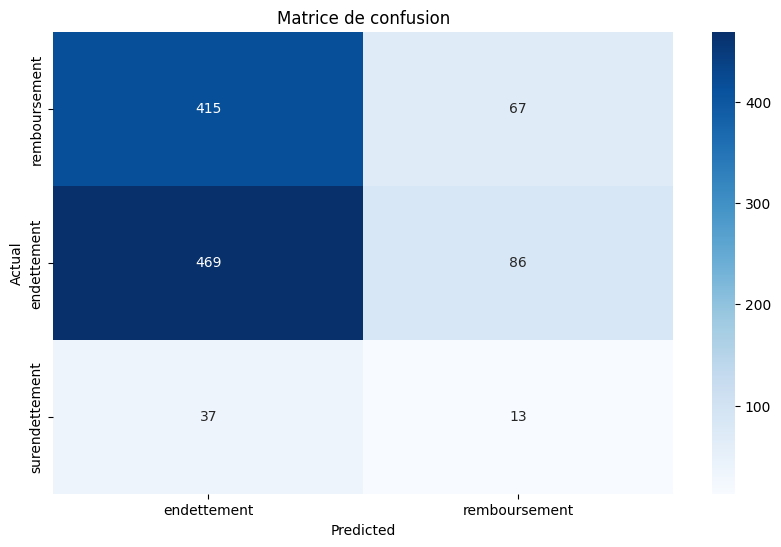

(0.49310027598896045,
 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100})

In [ ]:
evaluate_vanilla_model(1, 0.90, data, verbose=True)

### Model Optimization

- **Optimisation des hyperparamètres et leur impact sur la feature selection** : Une fois qu'on sait entraîner puis tester les performances d'un modèle, il nous reste à chercher les paramètres `x` et `q` optimaux (Cross-Validation) et observer si/comment la feature selection établie par le ridge change en fonction de ``x`` et ``q``
- **Redefinition de la target** : la target de classification etait définie par la variation relative de la dette horizon `x` jours mais on pourrait tout à fait imaginer de la definir par rapport à un depassement d'un niveau de volatilité seuil `s` ou variation cumulée pour prendre en compte tous le chemin entre ``t`` et ``t+x``  
- **Optimiser la ``classification_threshold``** :  selon si on prefere une precision elevé ou un recall élevé, par rapport au fait que le cout de faire l'erreur de classifier un surendettement en remboursement était pire que toute autre missclassfication car les variations relatives aux surendettement étaient plus violentes que les variation relatives aux remboursement (https://scikit-learn.org/stable/modules/classification_threshold.html)

- **Bonus** : 
    - **Transformation des données et feature augmentation** : rajouter des features notamment liées à `debt_amt`. Aussi, on peut chercher à transformer nos données (``gold price`` ``inflation-ajusted``, ``debt_amt`` déflaté du ``GDP`` ou GDP/hab)
    - **Incorporation des données macroéconomiques** : Ajouter des indicateurs macroéconomiques disponible grâce à l'API tels que le ``taux de chômage``, ``inflation`` (TIPS and CPI), et les ``taux d'intérêt`` pour améliorer les prédictions.
    - **Analyse comparative des modèles** : De la classification à la regression (logistique). Tester différents types de boosted trees, puis voire si l'implémentation de RNN comme LSTM pour prendre en compte les relations de dépendence temporelle des time series permet d'ameliorer les performances.
    - **Analyse de la saisonnalité** : Étudier les effets saisonniers sur les prix de l'or et la dette américaine -> faire varier l'échelle des données (jusque-là on travaillait avec du daily mais comme on l'a vu dans la partie Granger Causality, il peut être intéressant de revenir à du ``weekly`` ou du ``monthly``) 



#### Threshold Tuning 

In [8]:
# Définition d'une matrice de coût pour la classification (se tromper sur la paire endettement/surendettement est moins grave que si remboursement)
COST_MATRIX = np.array([
    [0, 10, 10],  # True label 0
    [10, 0, 1],   # True label 1
    [10, 1, 0]    # True label 2
])

def cost_sensitive_metric(y_true, y_pred,cost_matrix=COST_MATRIX):
    """
    Custom cost-sensitive metric based on a cost matrix
    """
    cost = 0
    for true, pred in zip(y_true, y_pred):
        cost += cost_matrix[int(true), int(pred)]
    return -cost / len(y_true)  # Negative because GridSearchCV maximizes the scorer

# Create a scorer
cost_scorer = make_scorer(cost_sensitive_metric, greater_is_better=True)

In [5]:
# Model Pipeline for Target Classification with Scaler, Features Selections and Classifier

def Tuned_Classifier(x,q, data, feature_selection=False):
    # Target creation
    data = DebtDeltaTransformer(x, q).transform(data)

    # Train test split on data
    X, y = data.drop(columns=['debt_delta', 'target']), data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    pipe = Pipeline(
        [
            ("scaling", StandardScaler()),
            # the reduce_dim stage is populated by the param_grid
            ("reduce_dim", "passthrough"),
            ("classify", GradientBoostingClassifier()),
        ]
    )

    N_FEATURES_OPTIONS = [3,5,7,9]
    CLASSIFIER_OPTIONS = {
        "n_estimators": [100,300],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5, 7],
    }

    param_grid = [
        {
            "reduce_dim": [PCA(iterated_power=7), NMF(max_iter=1_000)],
            "reduce_dim__n_components": N_FEATURES_OPTIONS,
            "classify__n_estimators": CLASSIFIER_OPTIONS["n_estimators"],
            "classify__learning_rate": CLASSIFIER_OPTIONS["learning_rate"],
            "classify__max_depth": CLASSIFIER_OPTIONS["max_depth"],
        },
        {
            "reduce_dim": [SelectKBest(mutual_info_classif)],
            "reduce_dim__k": N_FEATURES_OPTIONS,
            "classify__n_estimators": CLASSIFIER_OPTIONS["n_estimators"],
            "classify__learning_rate": CLASSIFIER_OPTIONS["learning_rate"],
            "classify__max_depth": CLASSIFIER_OPTIONS["max_depth"],
        },
    ]

  
    if feature_selection:
        # TimeSeriesSplit and GridSearchCV
        grid = GridSearchCV(pipe, cv=TimeSeriesSplit(n_splits=5), param_grid=param_grid, scoring=cost_scorer) # TunedThresholdClassifierCV in version 1.5 of sklearn would be better

    else:
        grid = GridSearchCV(GradientBoostingClassifier(), cv=TimeSeriesSplit(n_splits=5), param_grid=CLASSIFIER_OPTIONS, scoring=cost_scorer) # TunedThresholdClassifierCV in version 1.5 of sklearn would be better

    grid.fit(X_train, y_train)
    return grid, X_test, y_test



In [ ]:
def evaluate_tuned_model(x, q, data, feature_select = False, verbose=False):
    
    model, X_test, y_test = Tuned_Classifier(x, q, data)
    
    # Prédiction des classes de la target
    y_pred = model.predict(X_test)

    if verbose:
        # Affichage des meilleurs paramètres et meilleure méthode de réduction de dimension
        print(f"Meilleurs paramètres: {model.best_params_}")
        if feature_select:
            print(f"Meilleure méthode de réduction de dimension: {model.best_estimator_.named_steps['reduce_dim']}")

        # Affichage du rapport de classification
        print(classification_report(y_test, y_pred))
        
        # Matrice de confusion
        confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
        plt.figure(figsize=(10, 6))
        heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Matrice de confusion')
        plt.show()

    return accuracy_score(y_test,y_pred), model

#### Tuned Model

In [ ]:
# Grid-Search like function to Fine Tune the model with x and q
param_grid = {
    'x': [1, 7, 28, 90],
    'q': [0.9, 0.95, 0.97, 0.99]
}

def fine_tune_model(param_grid, verbose=False, feature_selection = False):
    best_score = 0
    best_params = None
    best_features = None
    for x in param_grid['x']:
        for q in param_grid['q']:
            
            score,model = evaluate_tuned_model(x,q,data)
            
            if verbose:
                print(f'Score for x={x} and q={q}: {score}')

            if score > best_score:
                best_score = score
                best_params = {'x': x, 'q': q}
                if feature_selection:
                    best_features = model.best_estimator_.named_steps['reduce_dim'].get_support(indices=True)
    
    return best_params, best_score, best_features

# Fine tune the model

best_params, best_score, best_features = fine_tune_model(param_grid, verbose=True)
print(f"Meilleurs paramètres trouvés: {best_params}")
print(f"Meilleure score: {best_score}")
print(f"Meilleures caractéristiques sélectionnées: {best_features}")

## Trading Strategy
---
On a un modèle qui nous permet de detecter des signaux concernant les variations futures (horizon `x` jours) de la dette américaine, il ne nous reste plus qu'à trouver une manière d'en tirer profit avec un stratégie de trading. Deux questions : Quoi trader ? Comment charger les positions ?

- **Proxy de la dette américaine** : verfier si on peut encoder la pente de la dette US par le ``spread d'un swap taux US 10y - 1y equi-std`` comme instrument pour notre stratégie de trading (donnée des swaps rates accessible ici : https://fred.stlouisfed.org/categories/32299)
- **Construction d'une stratégie basée sur le modèle de classification** : 
    - On regarde le signal donnée par le modèle de classification optimisé pour savoir si on long ou short
    - Pour charger les positions on peut utiliser la methode ``predict_proba`` pour avoir les probas de notre estimateur de classification
- **Backtesting des stratégies de trading** : Mettre en place un environnement de backtesting pour évaluer les performances des stratégies de trading basées sur les modèles prédictifs et sur un proxy de la dette américaine comme instrument tradable

In [41]:
# Your FRED API Key
API_KEY = "87e41f72558991abc233208c13775702"

series_ids = {
    "10y": "DSWP10", 
    "1y": "DSWP1",
    "3y": "DSWP3",
    "5y": "DSWP5",
}

# Base URL for FRED API
BASE_URL = "https://api.stlouisfed.org/fred/series/observations"

def fetch_swaps_data(series_id):
    """Fetch data from FRED API for a given series ID."""
    params = {
        "series_id": series_id,
        "api_key": API_KEY,
        "file_type": "json"
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()["observations"]
        df = pd.DataFrame(data)
        df["value"] = pd.to_numeric(df["value"], errors="coerce")  
        df["date"] = pd.to_datetime(df["date"]) 
        return df[["date", "value"]]
    else:
        print(f"Error fetching data for series {series_id}: {response.status_code}")
        return pd.DataFrame()

data_1y = fetch_swaps_data(series_ids["1y"])
data_3y = fetch_swaps_data(series_ids["3y"])
data_5y = fetch_swaps_data(series_ids["5y"])
data_10y = fetch_swaps_data(series_ids["10y"])

data_frames = [data_1y, data_3y, data_5y, data_10y]
swaps_data = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames)
swaps_data.columns = ['date', '1y', '3y', '5y', '10y']
swaps_data.set_index('date', inplace=True)
swaps_data

,1y,3y,5y,10y
date,,,,
2000-07-03,7.10,7.17,7.17,7.24
2000-07-04,NaN,NaN,NaN,NaN
2000-07-05,7.03,7.07,7.08,7.14
2000-07-06,7.07,7.14,7.16,7.21
2000-07-07,7.01,7.06,7.07,7.14
...,...,...,...,...
2016-10-24,0.99,1.15,1.30,1.61
2016-10-25,1.00,1.15,1.29,1.59
2016-10-26,1.01,1.18,1.33,1.64


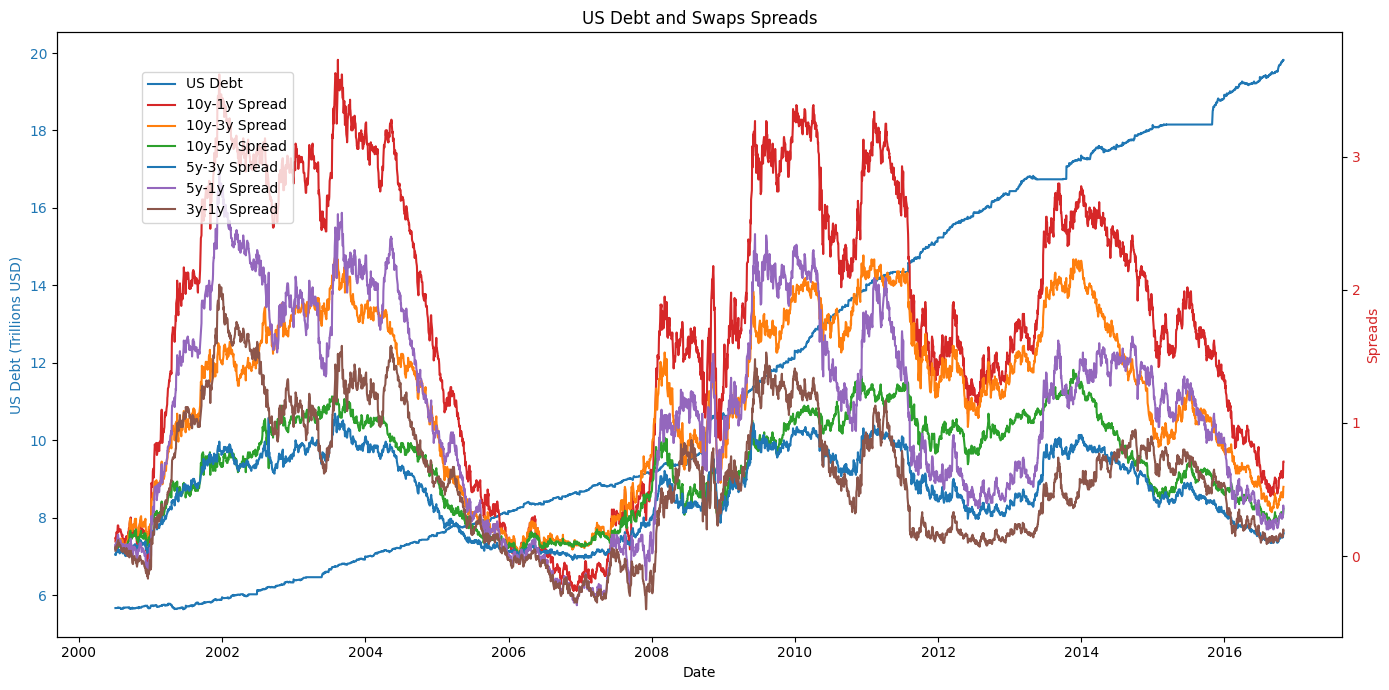

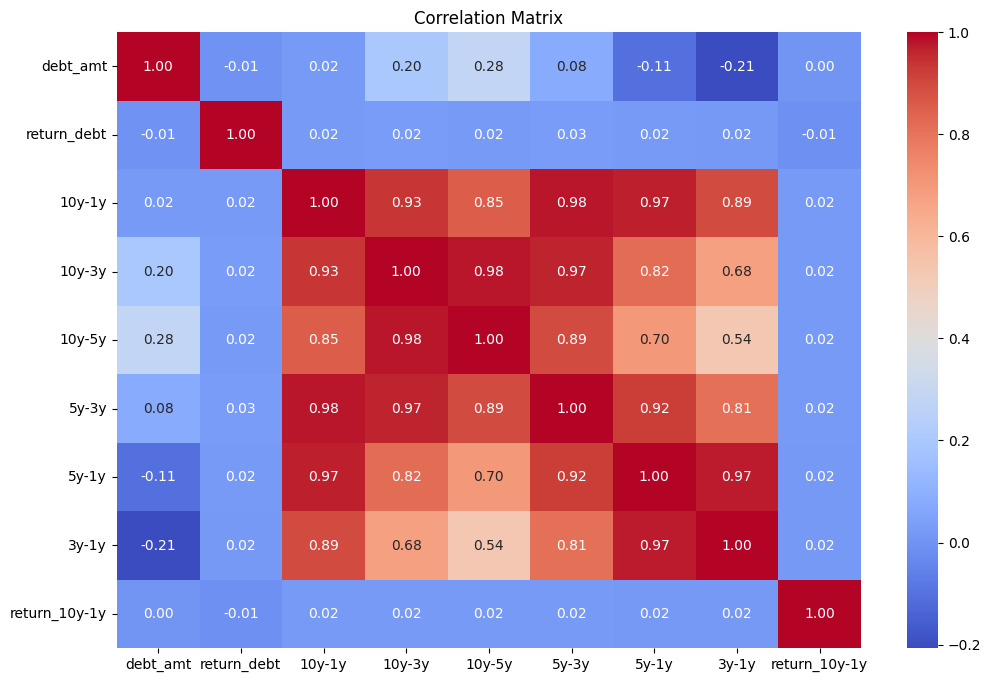

In [43]:
# All spreads between the different swaps
spread_data = pd.DataFrame(index=swaps_data.index)
spread_data['10y-1y'] = swaps_data['10y'] - swaps_data['1y']
spread_data['10y-3y'] = swaps_data['10y'] - swaps_data['3y']
spread_data['10y-5y'] = swaps_data['10y'] - swaps_data['5y']
spread_data['5y-3y'] = swaps_data['5y'] - swaps_data['3y']
spread_data['5y-1y'] = swaps_data['5y'] - swaps_data['1y']
spread_data['3y-1y'] = swaps_data['3y'] - swaps_data['1y']


# Merge the spreads with the debt data
debt_data['return_debt'] = debt_data['debt_amt'].pct_change(1)
spread_data['return_10y-1y'] = spread_data['10y-1y'].pct_change(1)

debt_and_spreads = pd.merge(debt_data, spread_data, left_index=True, right_index=True)
debt_and_spreads.dropna(inplace=True)

# plot spread and debt data
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the debt data
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('US Debt (Trillions USD)', color=color)
ax1.plot(debt_and_spreads.index, debt_and_spreads['debt_amt'], color=color, label='US Debt')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot the spreads
ax2 = ax1.twinx()
ax2.set_ylabel('Spreads', color='tab:red')
ax2.plot(debt_and_spreads.index, debt_and_spreads['10y-1y'], color='tab:red', label='10y-1y Spread')
ax2.plot(debt_and_spreads.index, debt_and_spreads['10y-3y'], color='tab:orange', label='10y-3y Spread')
ax2.plot(debt_and_spreads.index, debt_and_spreads['10y-5y'], color='tab:green', label='10y-5y Spread')
ax2.plot(debt_and_spreads.index, debt_and_spreads['5y-3y'], color='tab:blue', label='5y-3y Spread')
ax2.plot(debt_and_spreads.index, debt_and_spreads['5y-1y'], color='tab:purple', label='5y-1y Spread')
ax2.plot(debt_and_spreads.index, debt_and_spreads['3y-1y'], color='tab:brown', label='3y-1y Spread')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add title and legend
plt.title('US Debt and Swaps Spreads')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

# compute correlation matrix
corr = debt_and_spreads.corr()

# plot the heatmap
plt.figure(figsize=(12, 8))
heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()





In [ ]:
us_bonds[["US1M","US6M","US1Y","US3Y"]].loc["1980-01-01":].plot()
plt.title('US Bonds Yields')
plt.xlabel('Date')
plt.ylabel('Yields in %')
plt.tight_layout()
plt.legend()
plt.show()

for column in us_bonds.columns:
    us_bonds[f'{column}_delta'] = (us_bonds[column].shift(-x) - us_bonds[column]) / us_bonds[column]
    
us_bonds_target_train = us_bonds.merge(pd.DataFrame(y_train),left_index=True,right_index=True)

{col: us_bonds_target_train["target"].corr(us_bonds_target_train[col]) for col in us_bonds_target_train.columns if col != "target"}